## Importing Necessary Libraries

In [26]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import pickle

## Importing Datset and Converting to pandas DataFrame

In [27]:
df = pd.read_csv("/home/rakin/ML_Projects/new.csv")
df = df.drop(['Unnamed: 0'],axis=1)

In [28]:
Y = df.values[:,-3:] # Target
X = df.values[:,:-3] # Features

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,shuffle=True)


In [30]:
# Normalize the target variables using MinMaxScaler
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
target1 = scaler2.fit_transform(Y_train[:,0].reshape(-1,1))  # 
target2 = scaler.fit_transform(Y_train[:,1].reshape(-1,1))
target3 = scaler.fit_transform(Y_train[:,2].reshape(-1,1))

# Concatenate the normalized target variables

Y_train = np.concatenate((target1, target2, target3), axis=1)


In [31]:
from keras.callbacks import *

# filepath='./val_aux_output_accuracy:{val_accuracy:.3f}-epochs:{epoch:03d}.hdf5'
filepath = './Best_model_6.hdf5'
#earlyStopping = EarlyStopping(monitor='val_aux_output_loss', patience=10, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='val_mse', verbose = 1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, mode='min',patience=2,verbose=1,min_lr=0.0001)
#callbacks_list = [checkpoint]
callbacks_list = [checkpoint,reduce_lr]

## Modify This cell - Try USing XGBoosRegressor, RandomForestRegressor, CatBoostRegressor

Epoch 1/300
15/16 [===========================>..] - ETA: 0s - loss: 0.1591 - mse: 0.1591
Epoch 1: val_mse improved from inf to 3989.38721, saving model to ./Best_model_6.hdf5
16/16 [==============================] - 3s 44ms/step - loss: 0.1568 - mse: 0.1568 - val_loss: 3989.3872 - val_mse: 3989.3872 - lr: 0.0010
Epoch 2/300
12/16 [=====================>........] - ETA: 0s - loss: 0.0453 - mse: 0.0453
Epoch 2: val_mse improved from 3989.38721 to 1164.96594, saving model to ./Best_model_6.hdf5
16/16 [==============================] - 0s 19ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 1164.9659 - val_mse: 1164.9659 - lr: 0.0010
Epoch 3/300
13/16 [=======================>......] - ETA: 0s - loss: 0.0259 - mse: 0.0259
Epoch 3: val_mse improved from 1164.96594 to 639.93347, saving model to ./Best_model_6.hdf5
16/16 [==============================] - 0s 19ms/step - loss: 0.0248 - mse: 0.0248 - val_loss: 639.9335 - val_mse: 639.9335 - lr: 0.0010
Epoch 4/300
12/16 [=====================>...

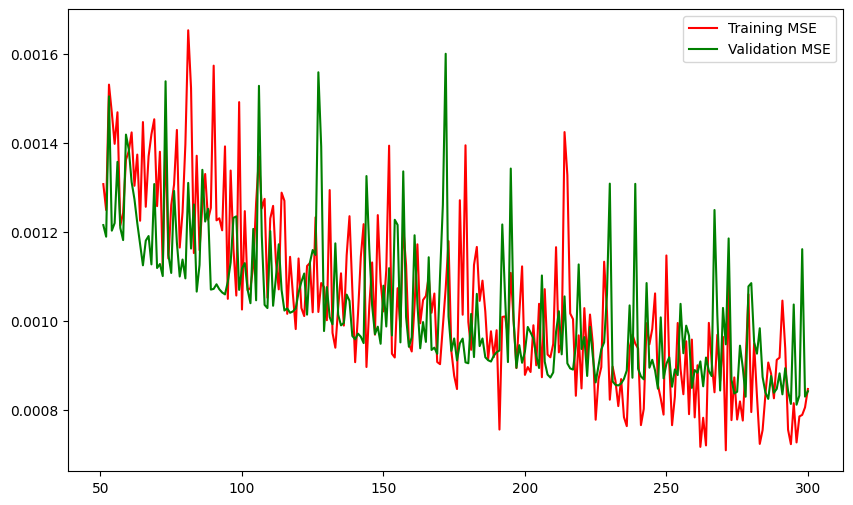

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 12)               48        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 12)                156       
                                                                 
 dense_9 (Dense)             (None, 64)                832       
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 512)               66048     
                                                      

In [32]:
model=tf.keras.Sequential([tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(12,input_dim=12,activation='relu'),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.Dense(24,activation='relu'),
                           tf.keras.layers.Dense(16,activation='relu'),
                           tf.keras.layers.Dense(3,activation='linear')
                           ])
model.compile(optimizer='RMSprop',loss='mse',metrics=['mse'])
history = model.fit(X_train,Y_train,epochs=300,batch_size=64,validation_split=0.3,callbacks=callbacks_list)

plt.figure(figsize=(10,6))
training_accuracy=history.history['loss'][50:]
epochs=range(51,301)
vali_ac=history.history['val_loss'][50:]
plt.plot(epochs,training_accuracy,'r',label='Training MSE')
plt.plot(epochs,vali_ac,'g',label='Validation MSE')
plt.legend()
plt.show()
model.summary()

In [33]:
def error_calculate(yhat,ytrue):
    error1 = 0
    error2 = 0
    error3 = 0
    for i in range(len(yhat)):
        error1 = error1 + ((ytrue[i,0]-yhat[i,0])**2)
        error2 = error2 +  ((ytrue[i,1]-yhat[i,1])**2)
        error3 = error3 + ((ytrue[i,2]-yhat[i,2])**2)
    print("MSE:",error1/len(yhat)," ",error2/len(yhat)," ",error3/len(yhat))
    return error1/len(yhat),error2/len(yhat),error3/len(yhat)
# Model = tf.keras.models.load_model(filepath)
# yhat = Model.predict(X_test)
# y1=scaler2.inverse_transform(yhat[:,0].reshape(-1,1))
# y2=scaler.inverse_transform(yhat[:,1:].reshape(-1,2))
# yhat = np.concatenate([y1,y2],axis=1)
# ytrue = Y_test
# error_calculate(yhat,ytrue)

Making DataFrame

In [32]:
# column = ['ROCOF(Predicted)','ROCOF(Actual)','Settling Frequency(Predicted)','Settling Frequency(Actual)','Nadir(Predicted)','Nadir(Actual)']
# result_df = pd.DataFrame(columns=column)
# result_df['ROCOF(Predicted)']= yhat[:,0]
# result_df['Settling Frequency(Predicted)']=yhat[:,1]
# result_df['Nadir(Predicted)']=yhat[:,2]
# result_df['ROCOF(Actual)']= ytrue[:,0]
# result_df['Settling Frequency(Actual)']=ytrue[:,1]
# result_df['Nadir(Actual)']=ytrue[:,2]
# result_df.to_csv("test_result.csv")

In [8]:
#KNNRegressor
knn = KNeighborsRegressor(n_neighbors=5,weights="distance",algorithm="auto",leaf_size=20,p=2)
model_KNN = MultiOutputRegressor(knn)
model_KNN.fit(X_train,Y_train)

#RF Regressor
rf = RandomForestRegressor(n_estimators = 10000,max_depth=10,min_samples_split=2,min_samples_leaf=1,max_features='sqrt', random_state = 42)
model_RF = MultiOutputRegressor(rf)
# model.compile(optimizer='RMSprop',loss='mse',metrics=['mse'])
model_RF.fit(X_train,Y_train)
#XGB Regressor
xgb = XGBRegressor(
                n_estimators=100,
                max_depth=3,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                alpha=0.1,
                reg_lambda = 0.1,
                objective='reg:squarederror')
model_XGB = MultiOutputRegressor(xgb)
model_XGB.fit(X_train,Y_train)


MultiOutputRegressor(estimator=XGBRegressor(alpha=0.1, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, ...))

In [12]:
Y_train.shape

(1396, 3)

In [10]:
# Saving ML models
# file name, I'm using *.pickle as a file extension
filename_RF = "random_forest.pickle"
filename_KNN = "knn.pickle"
filename_XGB = "xgb.pickle"

# save model
pickle.dump(model_RF, open(filename_RF, "wb"))
pickle.dump(model_KNN, open(filename_KNN, "wb"))
pickle.dump(model_XGB, open(filename_XGB, "wb"))

### Ensembling 3 Models and Inserting To a Neural Network

In [59]:
# filepath='./val_aux_output_accuracy:{val_accuracy:.3f}-epochs:{epoch:03d}.hdf5'
filepath_ens = './Best_model_ensemble.hdf5'
#earlyStopping = EarlyStopping(monitor='val_aux_output_loss', patience=10, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
checkpoint = ModelCheckpoint(filepath_ens, monitor='val_mse', verbose = 1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, mode='min',patience=2,verbose=1,min_lr=0.0001)
#callbacks_list = [checkpoint]
callbacks_list = [checkpoint,reduce_lr]
def ensemble_training(model_RF,model_KNN,model_XGB,X_train,Y_train):
    y1 = model_RF.predict(X_train)
    y2 = model_KNN.predict(X_train)
    y3 = model_XGB.predict(X_train)
    Y_tr = np.concatenate([y1,y2,y3],axis=1)
    print(Y_tr.shape)
    model=tf.keras.Sequential([tf.keras.layers.Dense(12,input_dim=9,activation='relu'),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.Dense(512,activation='relu'),
                           tf.keras.layers.Dense(265,activation='relu'),
                           tf.keras.layers.Dense(24,activation='relu'),
                           tf.keras.layers.Dense(16,activation='relu'),
                           tf.keras.layers.Dense(3,activation='linear')
                           ])
    
    model.compile(optimizer='RMSprop',loss='mse',metrics=['mse'])
    
    history = model.fit(Y_tr,Y_train,epochs=300,batch_size=32,validation_split=0.3,callbacks=callbacks_list)
    model.summary()
    return history, model
    

In [60]:
history, mod = ensemble_training(model_RF,model_KNN,model_XGB,X_train,Y_train)

(1396, 9)
Epoch 1/300
31/31 [==============================] - ETA: 0s - loss: 0.0616 - mse: 0.0616
Epoch 1: val_mse improved from inf to 0.01142, saving model to ./Best_model_ensemble.hdf5
31/31 [==============================] - 5s 55ms/step - loss: 0.0616 - mse: 0.0616 - val_loss: 0.0114 - val_mse: 0.0114 - lr: 0.0010
Epoch 2/300
30/31 [============================>.] - ETA: 0s - loss: 0.0161 - mse: 0.0161
Epoch 2: val_mse did not improve from 0.01142
31/31 [==============================] - 1s 32ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0191 - val_mse: 0.0191 - lr: 0.0010
Epoch 3/300
31/31 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0122
Epoch 3: val_mse improved from 0.01142 to 0.00436, saving model to ./Best_model_ensemble.hdf5
31/31 [==============================] - 1s 35ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0044 - val_mse: 0.0044 - lr: 0.0010
Epoch 4/300
31/31 [==============================] - ETA: 0s - loss: 0.0097 - mse: 0.0097
E

In [61]:
def model_inference(model,X_test,Y_test,model_KNN,model_XGB,model_RF):
    y1 = model_RF.predict(X_test)
    y2 = model_KNN.predict(X_test)
    y3 = model_XGB.predict(X_test)
    X = np.concatenate([y1,y2,y3],axis=1)
    yhat = model.predict(X)
    Y1=scaler2.inverse_transform(yhat[:,0].reshape(-1,1))
    Y2=scaler.inverse_transform(yhat[:,1:].reshape(-1,2))
    yhat = np.concatenate([Y1,Y2],axis=1)
    ytrue = Y_test
    x, y, z = error_calculate(yhat,ytrue)
    return x, y, z

## Comparison Between 4 Models

In [54]:
comp_columns = ['Model Name','ROCOF','Settling Frequency','Nadir']
comparison_df = pd.DataFrame(columns = comp_columns)

In [55]:
def find_error(model,X_test,Y_test):
    yhat = model.predict(X_test)
    y1=scaler2.inverse_transform(yhat[:,0].reshape(-1,1))
    y2=scaler.inverse_transform(yhat[:,1:].reshape(-1,2))
    yhat = np.concatenate([y1,y2],axis=1)
    ytrue = Y_test
    x, y, z = error_calculate(yhat,ytrue)
    return x, y, z
    

In [62]:
model = tf.keras.models.load_model(filepath)
rocof_ANN,setl_ANN,nadir_ANN = find_error(model,X_test,Y_test)
model = model_KNN
rocof_KNN,setl_KNN,nadir_KNN = find_error(model,X_test,Y_test)
model = model_RF
rocof_RF,setl_RF,nadir_RF = find_error(model,X_test,Y_test)
model = model_XGB
rocof_XGB,setl_XGB,nadir_XGB = find_error(model,X_test,Y_test)
model_ensemble = tf.keras.models.load_model(filepath_ens)
rocof_ensemble, setl_ensemble,nadir_ensemble = model_inference(model_ensemble,X_test,Y_test,model_KNN,model_XGB,model_RF)



19/19 [==============================] - 0s 4ms/step
MSE: 0.00016884004574597536   0.030201617967601253   0.018410582632527973
MSE: 2.2623759936529936e-05   0.00852064085094129   0.0008465672845918053
MSE: 4.50857046167494e-05   0.008590601813766438   0.005287016206090671
MSE: 2.767323223115843e-05   0.009390174292764212   0.0024225778704086006
19/19 [==============================] - 0s 5ms/step
MSE: 6.311049515536969e-05   0.004704647571856369   0.0017641985928518822


In [63]:
comparison_df['Model Name'] = ['DNN','KNN','RF','XGB','Merged Model']
comparison_df['ROCOF']= [rocof_ANN,rocof_KNN,rocof_RF,rocof_XGB,rocof_ensemble]
comparison_df['Settling Frequency']= [setl_ANN,setl_KNN,setl_RF,setl_XGB,setl_ensemble]
comparison_df['Nadir']=[nadir_ANN,nadir_KNN,nadir_RF,nadir_XGB,nadir_ensemble]

comparison_df.to_csv("comparison_result_updated.csv")